# Why some people write very long product reviews ? 
## by (Alaaeldin Zaky)

## Investigation Overview

> In product reviewing, you would find very long product reviews. What causes some text reviews to be much longer than others ? Are positive reviews usually longer? Are there some special product categories/brands that affect the length of the reviews ? 
These questions we are going to address in this investigation.  

## Dataset Overview

> This dataset consists of a list of over 71,045 reviews from 1,000 different products provided by Datafiniti's Product Database. The dataset includes the text and title of the review, the name and manufacturer of the product, reviewer metadata, and more.

In [18]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [19]:
# load in the dataset into a pandas dataframe
df = pd.read_csv("GrammarandProductReviews.csv")

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

In [20]:
#Drop unneeded columns(features)
df_reviews = df[["id", "brand", "categories", "manufacturer", "reviews.id", "reviews.rating", "reviews.doRecommend", "reviews.title", "reviews.text"]]

# Remove all NAN values for review.text
df_reviews.dropna(subset=['reviews.text'], inplace=True)

#Feature Engineering: Adding a feature for the length of the text reviews & title review
df_reviews['reviews.text_len'] = df_reviews['reviews.text'].apply(len)
df_reviews['reviews.title_len'] = df_reviews.dropna(subset=['reviews.title'])['reviews.title'].apply(len)


## Distribution of Product Rating

> This count plot shows the distribution of star ratings for the products in this dataset. As shown the data is imbalanced, as  most of the rating reviews are positive reviews. 

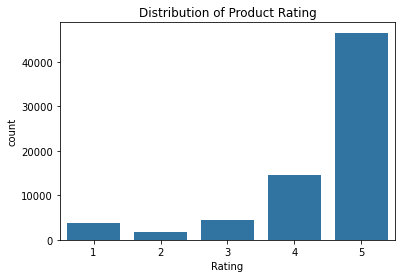

In [21]:
base_color = sb.color_palette()[0]
sb.countplot(data=df_reviews, x='reviews.rating', color=base_color)
plt.xlabel("Rating");
plt.title("Distribution of Product Rating");

In [22]:
def list_similarities(list_all):
    """ Estimates the proportion of similiraty between multiple lists and returns the lists with similarites higher than 50%.
    Arguments: 
    list_all: list of lists - the function finds the similarities between all the combinations of these lists
    returns: a list of tuples - each tuple represents the indeces of the the two similar lists
    """
    list_of_similarities_index = []
    for list_idx, list_a in enumerate(list_all):
        for idx in range(list_idx + 1, len(list_all)):
            list_b = list_all[idx]
            similarity_percentage = len(set(list_a) & set(list_b)) / max(len(list_a), len(list_b))
            #print("{:3f}    ({},{})".format(similarity_percentage,list_idx, idx))
            if(similarity_percentage >= 0.5):
                list_of_similarities_index.append((list_idx, idx))
    return list_of_similarities_index

# Get the index for categories 
categories_index = df_reviews['categories'].value_counts().index
#transfrom type "pandas.core.indexes.base.Index" to list 
categories_list = categories_index.format()

# List of lists .. each list has strings for all sub-category names in each category  
categories_longname_list = [label.split(',') for label in categories_list]

# Find the similarites between categories
similarities_output = list_similarities(categories_longname_list)

# get list for lists for indeces: index_lists
index_lists  = []
for similar_tuple in similarities_output:
    list_found = False
    for index_list in index_lists:
        if similar_tuple[0] in index_list:
            index_list.append(similar_tuple[1])
            list_found = True
            break
    if list_found == False:
        index_lists.append([similar_tuple[0], similar_tuple[1]])
        
def most_frequent(List): 
    """ Get the most frequent word.
    List: list of strings
    returns: The most frequent string in 'List'
    """
    return max(set(List), key = List.count) 

#Construct a dictionary: {"Category": most frequent word in similar category names}
category_dict = {}
for index_list in index_lists:
    category_name_list = []
    for category in index_list:
        temp_list =  df_reviews['categories'].value_counts().index[category].split(',')
        category_name_list.extend(temp_list)
    category_new_name = most_frequent(category_name_list)
    category_list = df_reviews['categories'].value_counts().index[index_list]
    category_dict.update(dict.fromkeys(category_list, category_new_name))
    
def generic_category_name(name):
    """Get the new category name.
    name: category name
    return: new generic category name
    """
    if name in category_dict:      
        return category_dict[name]
    else:
        return name.split(',')[0]

df_reviews['generic_categories'] = df_reviews['categories'].apply(generic_category_name)

## Distribution of Product Category

> After doing some manipulation and feature enginnering to the dataset, the count plot for the product categories is plotted. 
The distribution shows that the dataset is concerned on some categories like movies and household essentials a lot more than other categories like food and kitchen & Dining. 

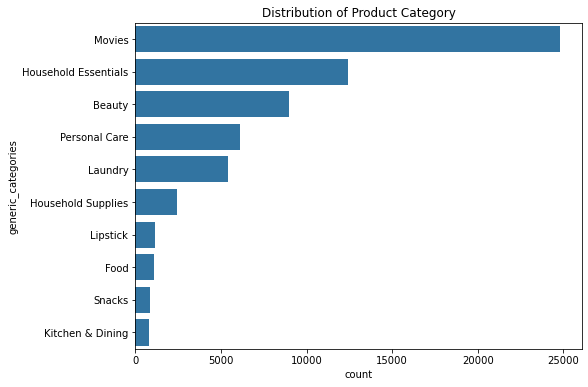

In [32]:
# Bar chart for the highest 10 categories (for the new generic category names)
plt.figure(figsize=[8, 6])
generic_categories_index = df_reviews['generic_categories'].value_counts()[:10].index
sb.countplot(data=df_reviews[df_reviews['generic_categories'].isin(generic_categories_index)], y='generic_categories', color=base_color, order=generic_categories_index);
plt.title("Distribution of Product Category");

## Distribution of Text Review Length

> Text review length in the dataset take on a very large range of values, from about 5 characters at the lowest, to more than 3000 charachters at the highest. Plotted on a logarithmic scale, the histogram of text reviews length of takes on a bimodal shape.
 

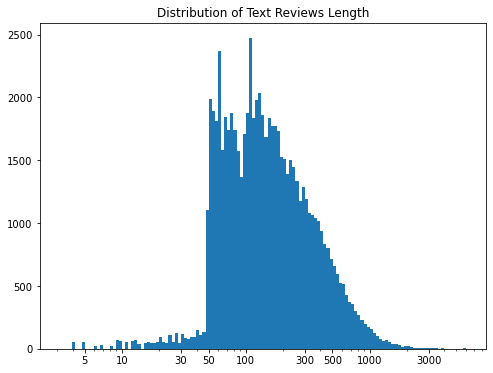

In [24]:
log_bins = 10 ** np.arange(0.5, np.log10(max(df_reviews['reviews.text_len'])) + 0.025, 0.025)
plt.figure(figsize = [8,6])
plt.hist(data=df_reviews, x='reviews.text_len', bins=log_bins);
plt.xscale('log')
plt.xticks([5, 10, 30, 50, 100, 300, 500, 1000, 3000], [5, 10, 30, 50, 100, 300, 500, 1000, 3000])
plt.title("Distribution of Text Reviews Length");

## Text review length vs. Rating 
> To get some insight about what are the factors for long text reviews, the box plot for the text review length is plotted versus all star rating levels. It could be observed that negative reviews tend to have a longer text reviews.

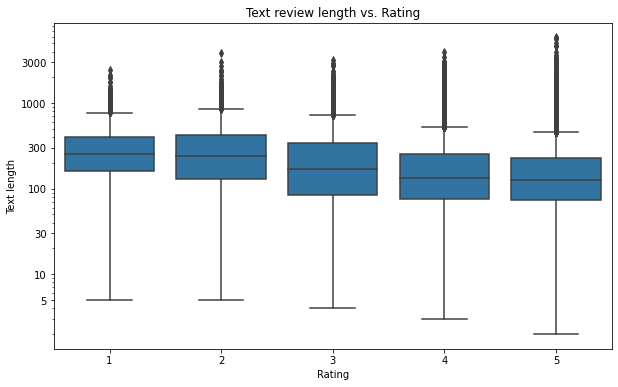

In [25]:
# Plot length of text's review vs review's rating 
plt.figure(figsize=[10,6])
sb.boxplot(data=df_reviews, x='reviews.rating', y='reviews.text_len', color=base_color)
plt.yscale('log')
plt.yticks([5, 10, 30, 100, 300, 1000, 3000], [5, 10, 30,100, 300, 1000, 3000])
plt.xlabel("Rating")
plt.ylabel("Text length");
plt.title("Text review length vs. Rating");

## Text Review Length vs. different Categories 
> To get more insight about our main feature, the box plot for the text review length is plotted versus different product categories. From this plot it could be observed that some categories such as beauty and home, personal care and home products tend to have a longer text reviews than other categories such as food and snacks. 

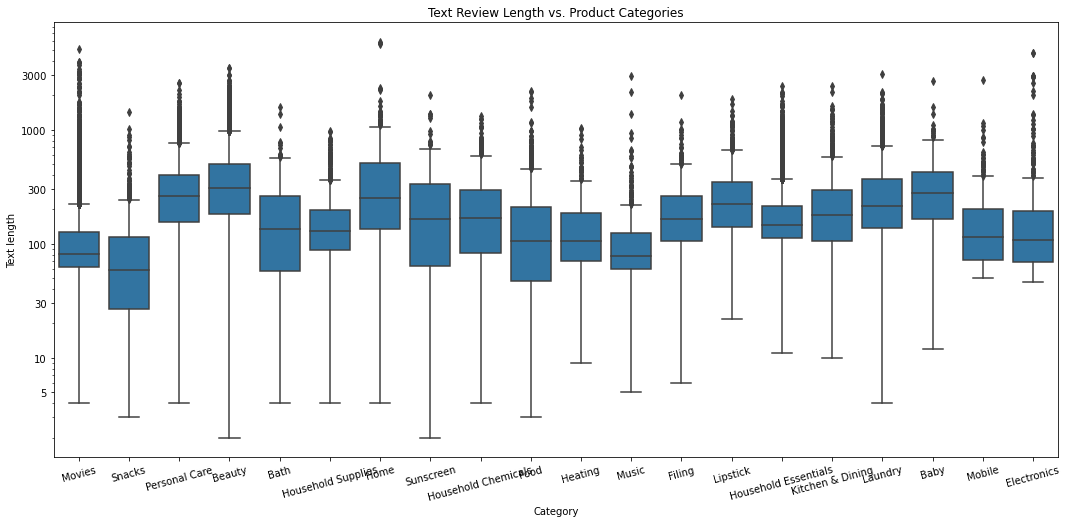

In [26]:
# Plot length of text's review vs Category 
bi_category_index = df_reviews['generic_categories'].value_counts()[:20].index
plt.figure(figsize=[18,8])
sb.boxplot(data=df_reviews[df_reviews['generic_categories'].isin(bi_category_index)], x='generic_categories', y='reviews.text_len', color=base_color)
plt.yscale('log')
plt.yticks([5, 10, 30, 100, 300, 1000, 3000], [5, 10, 30, 100, 300, 1000, 3000])
plt.xticks(rotation=15)
plt.xlabel("Category")
plt.ylabel("Text length");
plt.title("Text Review Length vs. Product Categories");

## Text Review Length by Rating and Product Categories 
> To have a good overview and a better understanding for our features, the distribution of the text review length is plotted for each star rating and for each category. 

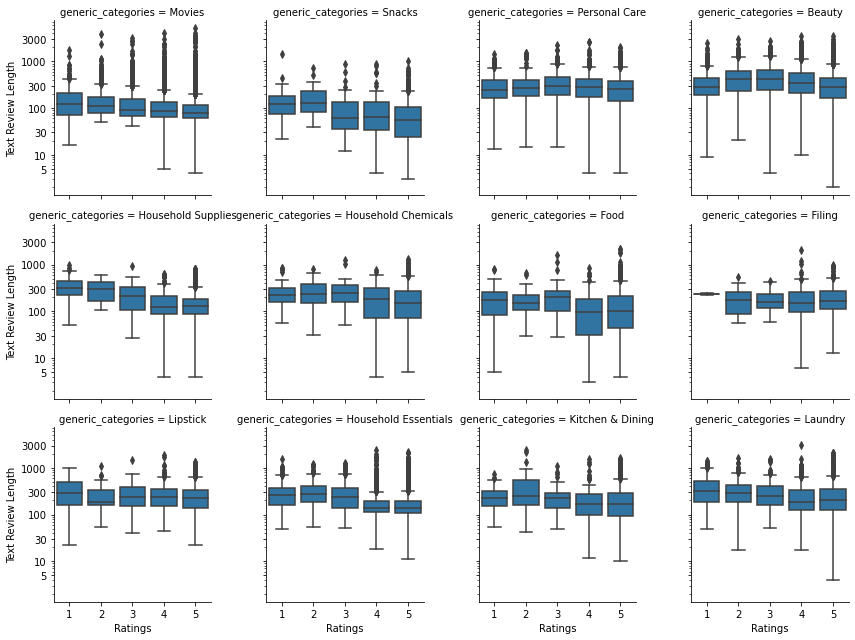

In [27]:
tri_category_index = df_reviews['generic_categories'].value_counts()[:12].index
g = sb.FacetGrid(data=df_reviews[df_reviews['generic_categories'].isin(tri_category_index)], col='generic_categories', margin_titles=True, col_wrap=4)
g.map(sb.boxplot, "reviews.rating", "reviews.text_len")
g.set_axis_labels("Ratings", "Text Review Length")
plt.yscale('log')
plt.yticks([5, 10, 30, 100, 300, 1000, 3000], [5, 10, 30, 100, 300, 1000, 3000]);

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert slide_deck_template.ipynb --to slides --post serve --template output_toggle`
> > !jupyter nbconvert explanatory_template.ipynb --to slides --post serve --no-input --no-prompt
> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!

## Conclsuion 
> From the previous analysis and those visulaizations, it could be concluded that generally people tend to write longer reviews when they are mad or dislike the product they bought so they would be more frustrated and have the motive to write more details about the review. This also tends to happen with some categories related to beauty and personal care more than movies and food. 

In [33]:
!jupyter nbconvert slide_deck_template.ipynb --to slides --no-input --no-prompt

[NbConvertApp] Converting notebook slide_deck_template.ipynb to slides
[NbConvertApp] Writing 445502 bytes to slide_deck_template.slides.html
